In [39]:
pip install  matplotlib

Note: you may need to restart the kernel to use updated packages.


In [49]:
import pandas as pd  # 导入 pandas 库，用于数据处理和分析

# 使用 pandas 的 read_excel 方法读取 Excel 文件
df = pd.read_excel('text_analysis_ad_sample.xlsx', index_col=0)

# 打印读取的 DataFrame，方便查看数据内容和结构
df

,index,商品名称,商品类别,出版年,广告文本,广告标题
0,1596,五华牌香烟[May Blossom],烟草制品,1932,兰勃脱白脱勒公司 五华牌香烟 佛及尼埃香烟 二十枝装每包售国币大洋二角 五十枝装每罐售国币...,"五华牌香烟,""兰勃脱白脱勒公司 五华牌香烟 佛及尼埃香烟"""
1,5627,韦廉士红色清导丸[Dr.Willams' Pink Pills For Pale People],药品,1918,讲求卫生为人生本性天理固然也 人生首贵逐日大便通畅有序为天然所当如此也如若大便不利大肠阻塞则...,韦廉士红色清导丸:'讲求卫生为人生本性天理固然也'
2,13532,大炮台香烟[Three Castles Cigarettes],烟草制品,1935,"香味馥郁,不让名花 另有三炮台出售","大炮台香烟,""香味馥郁 不让名花"""
3,1133,婴孩自己药片[Baby's Own],药品,1930,差肩儿女 秀慧康强 闽有佳音讃羡婴孩自己药片 每年此际小儿患肠胃病者甚多而尤以南方各地天气翳...,"婴孩自己药片,""差肩儿女 秀慧康强 闽有佳音赞美婴孩自己药片"""
4,3146,亚士北罗药片[Aspro],药品,1933,何以亚士北罗是妇女们的腻友？各国妇女力证亚士北罗药片是她们最需要的药物！为什么？她们的经验知...,"亚士北罗药片,""妇女之腻友"""
...,...,...,...,...,...,...
495,14176,安住蚊烟香,化肥及杀虫剂,1935,安住蚊烟香 臭虫立毙药粉 世界第一名产 安住蚊烟香 蚊见逃慌慌 暑夜不用帐 包睡到天光 汉口...,"安住蚊烟香,""世界第一名产"""
496,11610,第威德润肠丸[DeWitt's],药品,1934,眉色清秀 气色壮旺 此第威德润肠丸之功也 第威德润肠丸系以草药炼制纯粹和平十分安全功能清理肠...,"第威德润肠丸,""眉色清秀 气色壮旺"""
497,10256,如意膏[She-Ko],药品,1934,汤火烫伤 立攃如意膏可免严重之后果 皮肤受伤当以灼烫最痛苦其又因此震激而致命者治疗灼烫止痛消...,"如意膏,""汤火烫伤 立攃如意膏可免严重之后果"""
498,9176,六零六药膏,药品,1923,清血解毒六零六 花柳梅毒瘰*疮疖癣疥**及筋骨酸痛四肢麻木半身疯*等症状虽异其发生之原理莫不...,"六零六,""清血解毒六零六"""


In [41]:
#分词
import jieba #中文分词
## 定义文本清洗函数
def clean_text(text):
    words = jieba.lcut(text)
    return' '.join(words) #将分词结果用空格连接成字符串
test = df['广告文本'][0] #从DataFrame的"广告文本"列中提取第一个广告文本作为测试样本
clean_text(test)
df['广告文本分词'] = df['广告文本'].apply(clean_text)
df

,index,商品名称,商品类别,出版年,广告文本,广告标题,广告文本分词
0,1596,五华牌香烟[May Blossom],烟草制品,1932,兰勃脱白脱勒公司 五华牌香烟 佛及尼埃香烟 二十枝装每包售国币大洋二角 五十枝装每罐售国币...,"五华牌香烟,""兰勃脱白脱勒公司 五华牌香烟 佛及尼埃香烟""",兰勃 脱白 脱勒 公司 五华 牌 香烟 佛及 尼埃 香烟 二十 枝装 每包 ...
1,5627,韦廉士红色清导丸[Dr.Willams' Pink Pills For Pale People],药品,1918,讲求卫生为人生本性天理固然也 人生首贵逐日大便通畅有序为天然所当如此也如若大便不利大肠阻塞则...,韦廉士红色清导丸:'讲求卫生为人生本性天理固然也',讲求 卫生 为 人生 本性 天理 固然 也 人生 首贵 逐日 大便 通畅 有序 为 天然...
2,13532,大炮台香烟[Three Castles Cigarettes],烟草制品,1935,"香味馥郁,不让名花 另有三炮台出售","大炮台香烟,""香味馥郁 不让名花""","香味 馥郁 , 不让 名花 另 有 三 炮台 出售"
3,1133,婴孩自己药片[Baby's Own],药品,1930,差肩儿女 秀慧康强 闽有佳音讃羡婴孩自己药片 每年此际小儿患肠胃病者甚多而尤以南方各地天气翳...,"婴孩自己药片,""差肩儿女 秀慧康强 闽有佳音赞美婴孩自己药片""",差肩 儿女 秀慧 康强 闽有 佳音 讃 羡 婴孩 自己 药片 每年 此际 小儿 ...
4,3146,亚士北罗药片[Aspro],药品,1933,何以亚士北罗是妇女们的腻友？各国妇女力证亚士北罗药片是她们最需要的药物！为什么？她们的经验知...,"亚士北罗药片,""妇女之腻友""",何以 亚士 北罗 是 妇女 们 的 腻友 ？ 各国 妇女 力证 亚士 北罗 药片 是 她们 ...
...,...,...,...,...,...,...,...
495,14176,安住蚊烟香,化肥及杀虫剂,1935,安住蚊烟香 臭虫立毙药粉 世界第一名产 安住蚊烟香 蚊见逃慌慌 暑夜不用帐 包睡到天光 汉口...,"安住蚊烟香,""世界第一名产""",安住 蚊烟香 臭虫 立毙 药粉 世界 第一名 产 安住 蚊烟香 蚊见 逃 慌...
496,11610,第威德润肠丸[DeWitt's],药品,1934,眉色清秀 气色壮旺 此第威德润肠丸之功也 第威德润肠丸系以草药炼制纯粹和平十分安全功能清理肠...,"第威德润肠丸,""眉色清秀 气色壮旺""",眉色 清秀 气色 壮旺 此 第 威德 润肠 丸 之功 也 第 威德 润肠 丸系 ...
497,10256,如意膏[She-Ko],药品,1934,汤火烫伤 立攃如意膏可免严重之后果 皮肤受伤当以灼烫最痛苦其又因此震激而致命者治疗灼烫止痛消...,"如意膏,""汤火烫伤 立攃如意膏可免严重之后果""",汤火 烫伤 立 攃 如意 膏 可免 严重 之 后果 皮肤 受伤 当以 灼烫 最 痛苦...
498,9176,六零六药膏,药品,1923,清血解毒六零六 花柳梅毒瘰*疮疖癣疥**及筋骨酸痛四肢麻木半身疯*等症状虽异其发生之原理莫不...,"六零六,""清血解毒六零六""",清血 解毒 六零 六 花柳 梅毒 瘰 * 疮 疖 癣疥 * * 及 筋骨 酸痛 四肢 麻...


In [50]:
# 将 clean_text 函数应用于 '广告文本' 列
test = df['广告文本'][0]  # 从 DataFrame 的 '广告文本' 列中提取第一个广告文本作为测试样本
cleaned_text = clean_text(test)  # 调用 clean_text 函数对文本进行分词和清洗
print(cleaned_text)  # 打印清洗后的文本结果

兰勃 脱白 脱勒 公司   五华 牌 香烟   佛及 尼埃 香烟     二十 枝装 每包 售 国币 大洋 二角   五十 枝装 每罐 售 国币 大洋   五角


In [43]:
#语料库准备
from gensim.test.utils import common_texts 
common_texts
[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]
corpus = df['广告文本'].apply(lambda x: x.split()).tolist() # 切分词语
for document in corpus:
    print(document)

['兰勃脱白脱勒公司', '五华牌香烟', '佛及尼埃香烟', '二十枝装每包售国币大洋二角', '五十枝装每罐售国币大洋', '五角']
['讲求卫生为人生本性天理固然也', '人生首贵逐日大便通畅有序为天然所当如此也如若大便不利大肠阻塞则胃失消化疾病头痛肝火上升胆汁不调口气积浊舌现黄苔诸恙接踵而起矣凡此皆须服用韦廉士大医生红色清导丸以利大便俾得体质强健百病不侵也况此丸之功力天然平和不尚霸烈', '广东省城医生学研究会*生先生来示云弟患大便秘结之症一月有余困苦万状难以言喻服用韦廉士红色清导丸数粒大便畅达于是常为服用身体爽健为半生以来所未有也如尊处无从购买韦廉士红色清导丸祈即邮票大洋六角至上海四川路九十六号韦廉士医生药局原班邮奉一瓶可也']
['香味馥郁,不让名花', '另有三炮台出售']
['差肩儿女', '秀慧康强', '闽有佳音讃羡婴孩自己药片', '每年此际小儿患肠胃病者甚多而尤以南方各地天气翳热*颣充斥之区为最然而刘君强逹（福州南台梅亭山馆）家有差肩儿女而均秀慧康强者果何法以致之乎刘君云鄙人对于贵局所出之婴孩自己药片甚佩其功效之霊验药性之和平舍下儿女常因食物不节发生消化不良肌热烦燥肚疼泻泻等症从前未知婴孩药片之功时感求医之苦今则凡遇上述诸症投以此片均得速愈是真有儿女之家庭不可不备之圣药也', '婴孩自己药片系韦廉士之儿科専药统治小儿食积腹痛发热便秘呕吐泄泻伤风痰厥出牙蛔虫等症逺东总发行上海江西路六十号韦廉士医生药局各埠药房均有代售']
['何以亚士北罗是妇女们的腻友？各国妇女力证亚士北罗药片是她们最需要的药物！为什么？她们的经验知到亚士北罗药片功能最宏大,安全,可靠,物质纯净,不含别种危险性药料,故妇女们最信用的只有亚士北罗药片！亚士北罗药片的功用:五分钟内立止各种痛症伤风感冒失眠一服即愈', '何以妇女们对于亚士北罗比丈夫和爱人更爱慕？婚前！未婚女子对爱人的爱情亲热得很利害但是不识趣的毛病侵害她更为利害在他月经来的时期最易使他感觉到最不安适的是头痛和肚痛两种毛病虽是他最亲爱的爱人也没法使他安适惟有亚士北罗药片可以立止他的头痛和肚痛回复他的安适和快乐亚士北罗药片才是他们最亲爱的腻友比爱人更爱慕故此妇女们对亚士北罗药片万分的信任和欢迎婚后！女子结了婚她的唯一责任就是养育儿女照料丈夫想尽两种责任她的唯一信赖就是亚士北罗药片遇着丈夫和儿女发生疾病的时候如头痛肚痛

In [44]:

# 自己训练词嵌入模型
from gensim.models import Word2Vec #训练 Word2Vec 模型
# 使用包含目标词语的语料
corpus = [
    ["医生", "治疗", "病人", "的", "疼痛"],
    ["神经", "系统", "与", "疼痛", "感知", "有关"],
    ["伤风", "会", "引起", "头痛", "和", "身体", "疼痛"]
]
# 训练词嵌入模型
model = Word2Vec(
    corpus, #训练语料
    window = 5, #训练算法考虑的当前词语与预测词语在一个句子中的最大距离（窗口大小）
    vector_size = 100, #自定义训练向量维度
    min_count = 1, #忽略所有总频数低于这个值的词语
    epochs = 10
)

# 保存训练好的模型
model.save('Word2vec_ad.model')

# 查看词向量
word_list = model.wv.index_to_key #获取词汇表
word_vectors = model.wv[word_list] #获取词向量

# 打印前5个词及其向量表示
for word, vector in list(zip(word_list, word_vectors))[:5]:
    print(f'{word}:{vector}')

疼痛:[-5.3604261e-04  2.3753358e-04  5.1032123e-03  9.0132076e-03
 -9.3040727e-03 -7.1171024e-03  6.4613624e-03  8.9776684e-03
 -5.0210962e-03 -3.7627930e-03  7.3827691e-03 -1.5353092e-03
 -4.5350678e-03  6.5579978e-03 -4.8597809e-03 -1.8190179e-03
  2.8802783e-03  9.9637383e-04 -8.2919635e-03 -9.4556818e-03
  7.3126415e-03  5.0709164e-03  6.7605251e-03  7.6007959e-04
  6.3567669e-03 -3.4082693e-03 -9.4411423e-04  5.7721576e-03
 -7.5272061e-03 -3.9369408e-03 -7.5120814e-03 -9.3243865e-04
  9.5397998e-03 -7.3226332e-03 -2.3384320e-03 -1.9388379e-03
  8.0801090e-03 -5.9328745e-03  4.5303121e-05 -4.7573014e-03
 -9.6091265e-03  5.0096898e-03 -8.7629417e-03 -4.3921131e-03
 -3.3409167e-05 -2.9384115e-04 -7.6647936e-03  9.6172309e-03
  4.9821693e-03  9.2364307e-03 -8.1609953e-03  4.4960212e-03
 -4.1421694e-03  8.2223059e-04  8.4985103e-03 -4.4671549e-03
  4.5187077e-03 -6.7922384e-03 -3.5527889e-03  9.4002625e-03
 -1.5770809e-03  3.1961480e-04 -4.1385340e-03 -7.6854392e-03
 -1.5118446e-03  2.47

In [45]:

#计算词语相似度
## 使用余弦相似度 wv 度量词对之间的语义接近度
## 余弦相似度的取值介于[-1，1]之间，-1表示语义完全相反，1表示语义完全相同，0表示毫无关系
print(model.wv.similarity('医生','疼痛'))
print(model.wv.similarity('医生','神经'))
print(model.wv.similarity('医生','伤风'))
print(model.wv.similarity('疼痛','神经'))
print(model.wv.similarity('伤风','疼痛'))
print(model.wv.similarity('神经','伤风'))

0.05431371
0.013243232
-0.14641044
0.079690516
0.016537841
-0.08381601


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

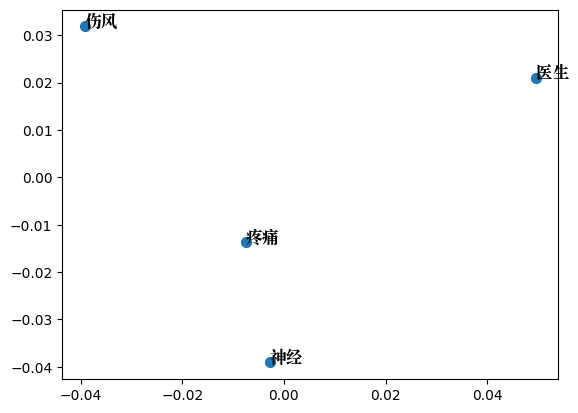

In [46]:
# 可视化词向量
words = ['医生', '疼痛', '神经', '伤风']
vectors = [model.wv[word] for word in words]

from sklearn.decomposition import PCA  # 语义空间降维，用于展示词语在二维空间的相对位置
# 指定中文字体路径（根据系统修改）
font_path = '/System/Library/Fonts/Supplemental/Songti.ttc'  # macOS系统
# 使用PCA降维
pca = PCA(n_components=2)
pca_result = pca.fit_transform(vectors)

import matplotlib.pyplot as plt  # 画图

# 绘制四个词语在二维空间的相对位置
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文
plt.figure()

# 取PCA降维结果中所有行的第一列和第二列数据绘制散点图，设置点的大小为50
plt.scatter(pca_result[:, 0], pca_result[:, 1], s=50)

for i, word in enumerate(words):
    from matplotlib.font_manager import FontProperties  # Import FontProperties for custom fonts
    font_prop = FontProperties(fname=font_path)  # Create a FontProperties object with the specified font path
    plt.annotate(word, (pca_result[i, 0], pca_result[i, 1]), fontproperties=font_prop, fontsize=12)

plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

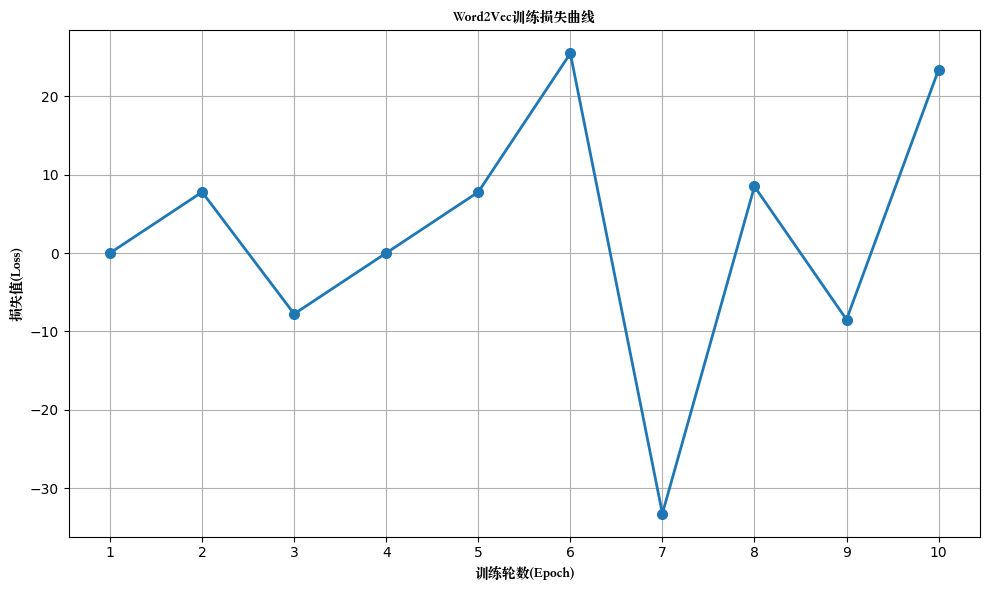


最终模型信息：
词汇表大小：16


In [47]:
#损失计算
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
#指定字体
font_path = '/System/Library/Fonts/Supplemental/Songti.ttc'
# 初始化模型（注意：不要设置 epochs，这里我们手动控制）
model = Word2Vec(
    vector_size=100,
    window=5,
    min_count=1,
    sg=1,
    compute_loss=True
)  
# 构建词汇表
model.build_vocab(corpus)

# 手动逐轮训练并记录损失
losses = []
previous_loss = 0
epochs = 10

for epoch in range(epochs):
    model.train(
        corpus,
        total_examples=model.corpus_count,
        epochs=1,
        compute_loss=True
    )
    current_loss = model.get_latest_training_loss()
    epoch_loss = current_loss - previous_loss
    losses.append(epoch_loss)
    previous_loss = current_loss
## 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), losses, 'o-',  color='#1f77b4',  # 主色：蓝色
    linewidth=2,          # 线条宽度
    markersize=7,         # 标记点大小
    label='Training Loss' # 添加图例标签
)
from matplotlib.font_manager import FontProperties  # Import FontProperties for custom fonts
font_prop = FontProperties(fname=font_path)  # Create a FontProperties object with the specified font path

plt.title('Word2Vec训练损失曲线', fontproperties=font_prop)
plt.xlabel('训练轮数(Epoch)', fontproperties=font_prop)
plt.ylabel('损失值(Loss)', fontproperties=font_prop)
plt.grid(True)
plt.xticks(range(1, epochs + 1))
plt.tight_layout()

plt.show()

## 打印最终模型的一些信息
print("\n最终模型信息：")
print(f"词汇表大小：{len(model.wv.key_to_index)}")